In [24]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. Load the dataset
data = torch.load("cleaned_automobile_train_dataset.pt")  # Load PyTorch data file
X = data["features"]  # Feature variables (13 features)
y = data["target"]  # Target variable

X = np.array(X)
y = np.array(y)

# 2. Set up 6-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

train_mse_list = []  # Store training set MSE
val_mse_list = []    # Store validation set MSE

# 3. Perform 6-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Compute OLS analytical solution: w = (X^T * X)^(-1) * X^T * y
    w_ols = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    
    # Compute predictions for training and validation sets
    y_train_pred = X_train @ w_ols
    y_val_pred = X_val @ w_ols
    
    # Compute MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)

# 4. Compute average MSE
avg_train_mse = np.mean(train_mse_list)
avg_val_mse = np.mean(val_mse_list)

# 5. Print results
print(f"Average Train MSE over 6 splits: {avg_train_mse:.4f}")
print(f"Average Validation MSE over 6 splits: {avg_val_mse:.4f}")


Average Train MSE over 6 splits: 7797180.5000
Average Validation MSE over 6 splits: 13361384.0000


1(b)

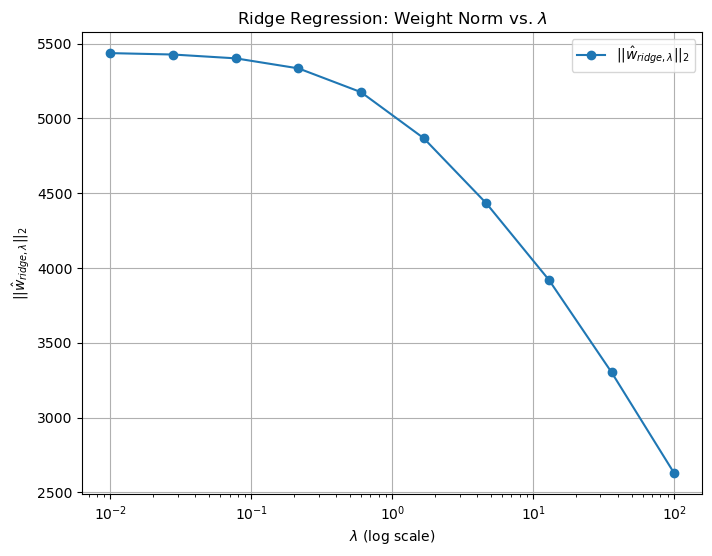

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# 1. Load dataset
data = torch.load("cleaned_automobile_train_dataset.pt")
X = data["features"]
y = data["target"]

# Convert PyTorch tensors to NumPy arrays
X_np = X.numpy()
y_np = y.numpy()

# Standardize features
scaler = StandardScaler()
X_np = scaler.fit_transform(X_np)

# 2. Compute the OLS solution w_ols (using pseudo-inverse)
w_ols = np.linalg.pinv(X_np.T @ X_np) @ X_np.T @ y_np
w_ols_norm = np.linalg.norm(w_ols, 2)

# 3. Select lambda values (wider range)
lambdas = np.logspace(-2, 2, 10)
w_norms = []

# 4. Compute Ridge regression solution and store L2 norms
for lam in lambdas:
    ridge_reg = Ridge(alpha=lam, fit_intercept=True)  # Allow intercept
    ridge_reg.fit(X_np, y_np)
    w_ridge = ridge_reg.coef_.flatten()
    w_norms.append(np.linalg.norm(w_ridge, 2))

# 5. Plot the results
plt.figure(figsize=(8, 6))
plt.plot(lambdas, w_norms, marker='o', linestyle='-', label=r"$||\hat{w}_{ridge,\lambda}||_2$")
plt.xscale("log")  # Log scale for lambda
plt.xlabel(r"$\lambda$ (log scale)")
plt.ylabel(r"$||\hat{w}_{ridge,\lambda}||_2$")
plt.title(r"Ridge Regression: Weight Norm vs. $\lambda$")
plt.legend()
plt.grid()
plt.show()

1(c)

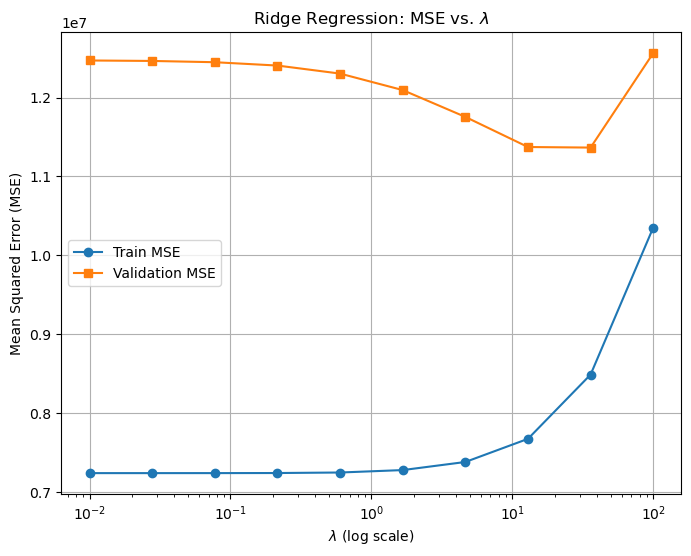

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. Load dataset
data = torch.load("cleaned_automobile_train_dataset.pt")
X = np.array(data["features"])
y = np.array(data["target"])

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 2. Define lambda values (wider range)
lambdas = np.logspace(-2, 2, 10)
train_mse_list = []
val_mse_list = []

# 3. Set up 6-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# 4. Perform Ridge regression with cross-validation
for lam in lambdas:
    train_mse_fold = []
    val_mse_fold = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train Ridge model
        ridge_reg = Ridge(alpha=lam, fit_intercept=True)
        ridge_reg.fit(X_train, y_train)

        # Compute MSE
        train_mse_fold.append(mean_squared_error(y_train, ridge_reg.predict(X_train)))
        val_mse_fold.append(mean_squared_error(y_val, ridge_reg.predict(X_val)))

    train_mse_list.append(np.mean(train_mse_fold))
    val_mse_list.append(np.mean(val_mse_fold))

# 5. Plot MSE vs. λ curve
plt.figure(figsize=(8, 6))
plt.plot(lambdas, train_mse_list, marker='o', linestyle='-', label="Train MSE")
plt.plot(lambdas, val_mse_list, marker='s', linestyle='-', label="Validation MSE")
plt.xscale("log")  # Log scale for lambda
plt.xlabel(r"$\lambda$ (log scale)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(r"Ridge Regression: MSE vs. $\lambda$")
plt.legend()
plt.grid()
plt.show()

1(d)

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. Load training data
data = torch.load("cleaned_automobile_train_dataset.pt")
X_train = np.array(data["features"])
y_train = np.array(data["target"])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# 2. Define lambda values (wider range)
lambdas = np.logspace(-2, 2, 10)
avg_val_mse_list = []

# 3. Perform 6-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

for lam in lambdas:
    val_mse_fold = []

    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train[train_index], X_train[val_index]
        y_t, y_v = y_train[train_index], y_train[val_index]

        # Train Ridge model
        ridge_reg = Ridge(alpha=lam, fit_intercept=True)  # Allow intercept
        ridge_reg.fit(X_t, y_t)

        # Compute validation MSE
        val_mse_fold.append(mean_squared_error(y_v, ridge_reg.predict(X_v)))

    avg_val_mse_list.append(np.mean(val_mse_fold))

# 4. Select the best lambda (smallest validation MSE)
best_lambda = lambdas[np.argmin(avg_val_mse_list)]
best_val_mse = min(avg_val_mse_list)

# 5. Load test data and standardize it
test_data = torch.load("cleaned_automobile_test_dataset.pt")
X_test = np.array(test_data["features"])
y_test = np.array(test_data["target"])
X_test = scaler.transform(X_test)  # Standardize test data

# 6. Retrain Ridge model using the best lambda and compute test MSE
ridge_best = Ridge(alpha=best_lambda, fit_intercept=True)
ridge_best.fit(X_train, y_train)
y_test_pred = ridge_best.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# 7. Print results
print(f"Best Lambda: {best_lambda}")
print(f"Average 6-fold Validation MSE: {best_val_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")



Best Lambda: 35.93813663804626
Average 6-fold Validation MSE: 11365613.0000
Test MSE: 24124976.0000


1(e)

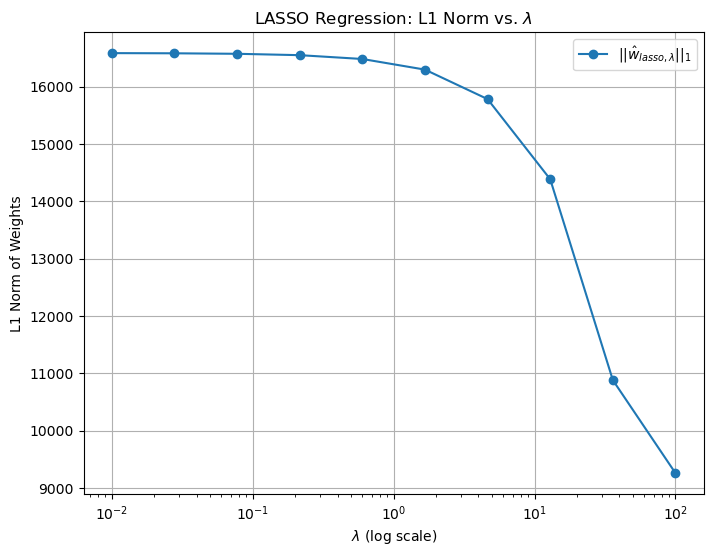

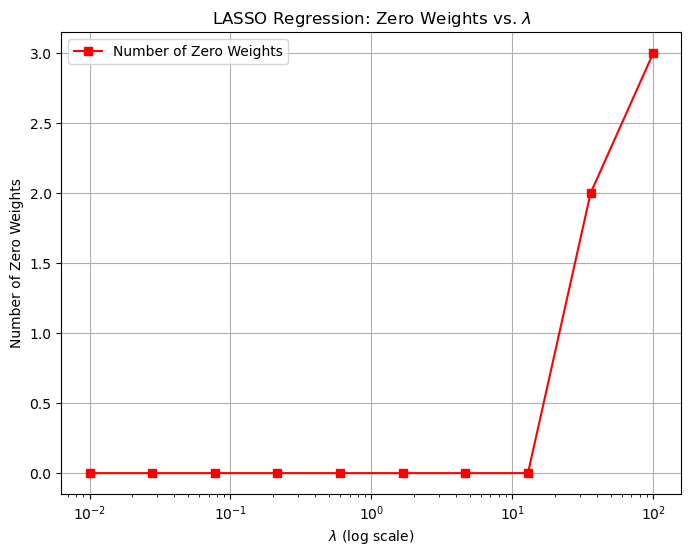

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 1. Load training data
data = torch.load("cleaned_automobile_train_dataset.pt")
X_train = np.array(data["features"])
y_train = np.array(data["target"])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# 2. Define lambda values (wider range)
lambdas = np.logspace(-2, 2, 10)  # Extended range for better regularization effect
l1_norms = []
zero_counts = []

# 3. Compute LASSO solutions for different lambda values
for lam in lambdas:
    lasso_reg = Lasso(alpha=lam, fit_intercept=True, max_iter=50000, tol=1e-4)
    lasso_reg.fit(X_train, y_train)
    w_lasso = lasso_reg.coef_

    # Compute L1 norm of weight vector
    l1_norms.append(np.sum(np.abs(w_lasso)))

    # Count the number of zero weights
    zero_counts.append(np.sum(w_lasso == 0))

# 4. Plot L1 Norm vs. λ
plt.figure(figsize=(8, 6))
plt.plot(lambdas, l1_norms, marker='o', linestyle='-', label=r"$||\hat{w}_{lasso,\lambda}||_1$")
plt.xscale("log")
plt.xlabel(r"$\lambda$ (log scale)")
plt.ylabel("L1 Norm of Weights")
plt.title(r"LASSO Regression: L1 Norm vs. $\lambda$")
plt.legend()
plt.grid()
plt.show()

# 5. Plot Number of Zero Weights vs. λ
plt.figure(figsize=(8, 6))
plt.plot(lambdas, zero_counts, marker='s', linestyle='-', color='red', label="Number of Zero Weights")
plt.xscale("log")
plt.xlabel(r"$\lambda$ (log scale)")
plt.ylabel("Number of Zero Weights")
plt.title(r"LASSO Regression: Zero Weights vs. $\lambda$")
plt.legend()
plt.grid()
plt.show()


1(f)

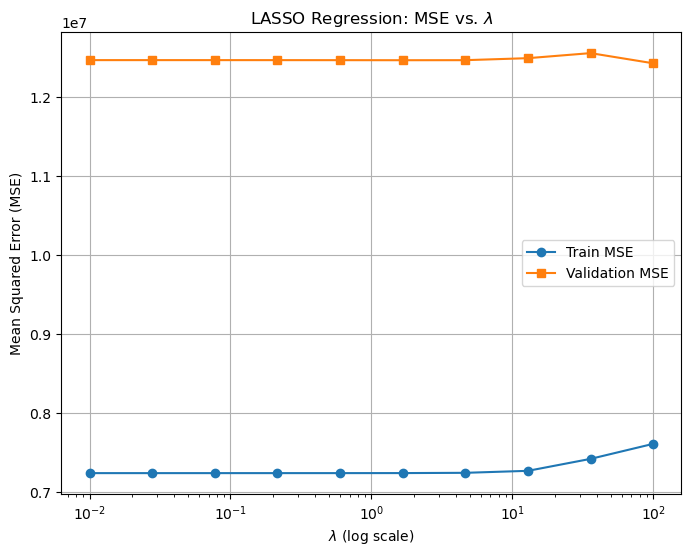

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. Load training data
data = torch.load("cleaned_automobile_train_dataset.pt")
X_train = np.array(data["features"])
y_train = np.array(data["target"])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


# 2. Define lambda values (wider range)
lambdas = np.logspace(-2, 2, 10)  # Extended range for better regularization effect
train_mse_list = []
val_mse_list = []

# 3. Perform 6-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

for lam in lambdas:
    train_mse_fold = []
    val_mse_fold = []

    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train[train_index], X_train[val_index]
        y_t, y_v = y_train[train_index], y_train[val_index]

        # Train LASSO model
        lasso_reg = Lasso(alpha=lam, fit_intercept=True, max_iter=50000, tol=1e-4)
        lasso_reg.fit(X_t, y_t)

        # Compute MSE
        train_mse_fold.append(mean_squared_error(y_t, lasso_reg.predict(X_t)))
        val_mse_fold.append(mean_squared_error(y_v, lasso_reg.predict(X_v)))

    train_mse_list.append(np.mean(train_mse_fold))
    val_mse_list.append(np.mean(val_mse_fold))

# 4. Plot MSE vs. λ curve
plt.figure(figsize=(8, 6))
plt.plot(lambdas, train_mse_list, marker='o', linestyle='-', label="Train MSE")
plt.plot(lambdas, val_mse_list, marker='s', linestyle='-', label="Validation MSE")
plt.xscale("log")
plt.xlabel(r"$\lambda$ (log scale)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(r"LASSO Regression: MSE vs. $\lambda$")
plt.legend()
plt.grid()
plt.show()

1(g)

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. Load training data
data = torch.load("cleaned_automobile_train_dataset.pt")
X_train = np.array(data["features"])
y_train = np.array(data["target"])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# 2. Define lambda values (wider range)
lambdas = np.logspace(-2, 2, 10)  # Extended range for better regularization effect
avg_val_mse_list = []

# 3. Perform 6-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

for lam in lambdas:
    val_mse_fold = []

    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train[train_index], X_train[val_index]
        y_t, y_v = y_train[train_index], y_train[val_index]

        # Train LASSO model
        lasso_reg = Lasso(alpha=lam, fit_intercept=True, max_iter=50000, tol=1e-4)
        lasso_reg.fit(X_t, y_t)

        # Compute MSE
        y_v_pred = lasso_reg.predict(X_v)
        val_mse_fold.append(mean_squared_error(y_v, y_v_pred))

    avg_val_mse_list.append(np.mean(val_mse_fold))

# 4. Select the best lambda (minimum validation MSE)
best_lambda = lambdas[np.argmin(avg_val_mse_list)]
best_val_mse = min(avg_val_mse_list)

# 5. Load test data
test_data = torch.load("cleaned_automobile_test_dataset.pt")
X_test = np.array(test_data["features"])
y_test = np.array(test_data["target"])

# Standardize test data
X_test = scaler.transform(X_test)

# 6. Retrain LASSO model using the best lambda and compute test MSE
lasso_best = Lasso(alpha=best_lambda, fit_intercept=True, max_iter=50000, tol=1e-4)
lasso_best.fit(X_train, y_train)
y_test_pred = lasso_best.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# 7. Compute LASSO sparsity (number of zero weights)
num_zero_weights = np.sum(lasso_best.coef_ == 0)

# 8. Print results
print(f"Best Lambda: {best_lambda}")
print(f"Average 6-fold Validation MSE: {best_val_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Number of zero entries in w_lasso,lambda*: {num_zero_weights}")

Best Lambda: 100.0
Average 6-fold Validation MSE: 12432608.0000
Test MSE: 19041318.0000
Number of zero entries in w_lasso,lambda*: 3


2(a)

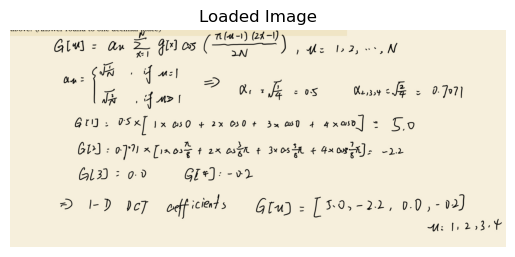

In [37]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image = Image.open("IMG_0026.jpg")  

# Display using Matplotlib
plt.imshow(image)
plt.axis("off")  # Hide axis labels
plt.title("Loaded Image")
plt.show()



In [38]:
import numpy as np

# Given signal g[x]
g = np.array([1, 2, 3, 4])
N = len(g)

# Compute DCT coefficients G[u] manually
G = np.zeros(N)

# Compute alpha_u values
alpha = np.array([np.sqrt(1/N) if u == 1 
                  else np.sqrt(2/N) for u in range(1, N+1)])

# Compute DCT coefficients
for u in range(1, N+1):  # u starts from 1 to N (indexing adjusted)
    sum_term = 0
    for x in range(1, N+1):  # x starts from 1 to N (indexing adjusted)
        sum_term += g[x-1] * np.cos(np.pi * (u-1) * (2*x-1) / (2*N))
    G[u-1] = alpha[u-1] * sum_term

# Round to one decimal place
G_rounded = np.round(G, 1)

# Print results
print("DCT Coefficients:", G_rounded)


DCT Coefficients: [ 5.  -2.2 -0.  -0.2]


2(b)

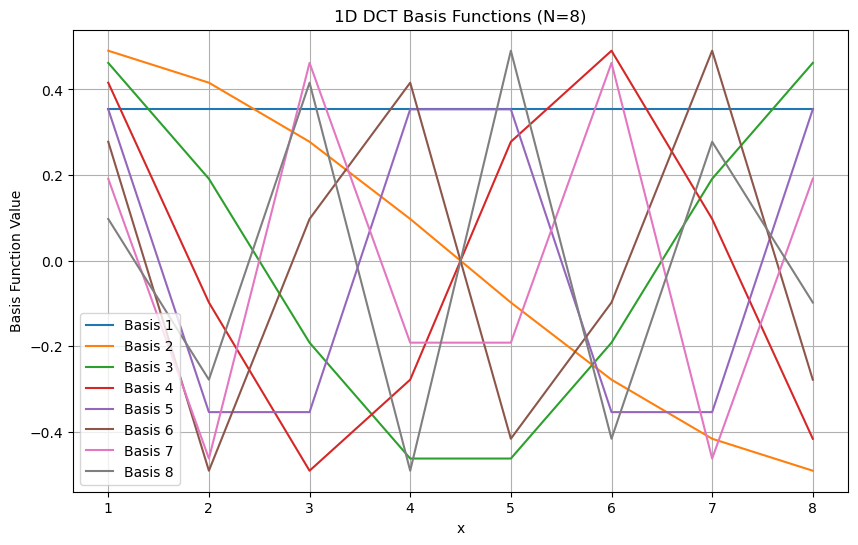

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define N
N = 8

# Compute the DCT basis functions
x = np.arange(1, N+1)  # x values from 1 to N
basis_functions = np.zeros((N, N))

for u in range(1, N+1):  # u starts from 1 to N
    alpha_u = np.sqrt(1/N) if u == 1 else np.sqrt(2/N)
    basis_functions[u-1, :] = alpha_u * np.cos(np.pi * (u-1) * (2*x-1) / (2*N))

# Plot all 8 basis functions
plt.figure(figsize=(10, 6))

for u in range(N):
    plt.plot(x, basis_functions[u, :], label=f'Basis {u+1}')

# Formatting the plot
plt.xlabel('x')
plt.ylabel('Basis Function Value')
plt.title('1D DCT Basis Functions (N=8)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


3(a)

In [1]:
import numpy as np

# Given DCT coefficients
G = np.array([14, -3.5, 3.5, 0])
N = len(G)

# Compute the inverse DCT (IDCT)
g_reconstructed = np.zeros(N)

for x in range(1, N+1):  # x 从 1 到 N
    sum_term = 0
    for u in range(1, N+1):  # u 从 1 到 N
        alpha_u = np.sqrt(1/N) if u == 1 else np.sqrt(2/N)
        sum_term += alpha_u * G[u-1] * np.cos(np.pi * (u-1) * (2*x-1) / (2*N))
    g_reconstructed[x-1] = sum_term

# Round to one decimal place
g_reconstructed_rounded = np.round(g_reconstructed, 1)

# Print results
print("Reconstructed signal g1(x):", g_reconstructed_rounded)

Reconstructed signal g1(x): [ 6.5  4.3  6.2 11. ]


3(b)

In [2]:
import numpy as np

# Given modified DCT coefficients (last two set to 0)
G_modified = np.array([14, -3.5, 0, 0])
N = len(G_modified)

# Compute the inverse DCT (IDCT) with sparse coefficients
g_reconstructed_sparse = np.zeros(N)

for x in range(1, N+1):  # x 从 1 到 N
    sum_term = 0
    for u in range(1, N+1):  # u 从 1 到 N
        alpha_u = np.sqrt(1/N) if u == 1 else np.sqrt(2/N)
        sum_term += alpha_u * G_modified[u-1] * np.cos(np.pi * (u-1) * (2*x-1) / (2*N))
    g_reconstructed_sparse[x-1] = sum_term

# Round to one decimal place
g_reconstructed_sparse_rounded = np.round(g_reconstructed_sparse, 1)

# Print results
print("Reconstructed signal g2(x):", g_reconstructed_sparse_rounded)


Reconstructed signal g2(x): [4.7 6.1 7.9 9.3]


3(c)

In [3]:
import numpy as np

# Define the ground truth signal
g_true = np.array([4, 6, 8, 10])

# Given reconstructed signals (from previous IDCT calculations)
g1 = g_reconstructed_rounded  # Full DCT reconstruction (replace with computed values)
g2 = g_reconstructed_sparse_rounded  # Sparse DCT reconstruction (replace with computed values)

# Compute MSE for full DCT reconstruction (g1)
mse_full = np.mean((g_true - g1) ** 2)

# Compute MSE for sparse DCT reconstruction (g2)
mse_sparse = np.mean((g_true - g2) ** 2)

# Determine which reconstruction has a smaller MSE
best_reconstruction = "g1 (Full DCT)" if mse_full < mse_sparse else "g2 (Sparse DCT)"

# Print results
print(f"MSE (Full DCT Reconstruction): {mse_full:.4f}")
print(f"MSE (Sparse DCT Reconstruction): {mse_sparse:.4f}")
print(f"Best reconstruction (smaller MSE): {best_reconstruction}")


MSE (Full DCT Reconstruction): 3.3450
MSE (Sparse DCT Reconstruction): 0.2500
Best reconstruction (smaller MSE): g2 (Sparse DCT)


4(a)

In [6]:
import numpy as np
import pandas as pd

# Define parameters
P, Q = 8, 8  # Image size
u_vals = [3, 5]  # Given u values
v_vals = [4, 2]  # Given v values

# Create grid for x and y
x = np.arange(1, P + 1)
y = np.arange(1, Q + 1)
X, Y = np.meshgrid(x, y)

# Function to compute DCT basis function
def dct_basis(u, v, P, Q):
    alpha_u = np.sqrt(1/P) if u == 1 else np.sqrt(2/P)
    beta_v = np.sqrt(1/Q) if v == 1 else np.sqrt(2/Q)
    return alpha_u * beta_v * np.cos(np.pi * (2*X-1) * (u-1) / (2*P)) * np.cos(np.pi * (2*Y-1) * (v-1) / (2*Q))

# Compute and print basis functions for given (u,v) pairs
basis_34 = dct_basis(3, 4, P, Q)
basis_52 = dct_basis(5, 2, P, Q)

# Convert to DataFrame for better visualization
df_basis_34 = pd.DataFrame(basis_34)
df_basis_52 = pd.DataFrame(basis_52)

# Print results
print("DCT Basis Function (u=3, v=4):")
print(df_basis_34)

print("\nDCT Basis Function (u=5, v=2):")
print(df_basis_52)


DCT Basis Function (u=3, v=4):
          0         1         2         3         4         5         6  \
0  0.192044  0.079547 -0.079547 -0.192044 -0.192044 -0.079547  0.079547   
1 -0.045060 -0.018664  0.018664  0.045060  0.045060  0.018664 -0.018664   
2 -0.226532 -0.093833  0.093833  0.226532  0.226532  0.093833 -0.093833   
3 -0.128320 -0.053152  0.053152  0.128320  0.128320  0.053152 -0.053152   
4  0.128320  0.053152 -0.053152 -0.128320 -0.128320 -0.053152  0.053152   
5  0.226532  0.093833 -0.093833 -0.226532 -0.226532 -0.093833  0.093833   
6  0.045060  0.018664 -0.018664 -0.045060 -0.045060 -0.018664  0.018664   
7 -0.192044 -0.079547  0.079547  0.192044  0.192044  0.079547 -0.079547   

          7  
0  0.192044  
1 -0.045060  
2 -0.226532  
3 -0.128320  
4  0.128320  
5  0.226532  
6  0.045060  
7 -0.192044  

DCT Basis Function (u=5, v=2):
          0         1         2         3         4         5         6  \
0  0.173380 -0.173380 -0.173380  0.173380  0.173380 -0.17338

4(b)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define parameters
P, Q = 2, 2  # Small 2x2 DCT
G = np.array([[1, 2], [3, 4]])  # Given DCT coefficients

# Create grid for x and y
x = np.arange(1, P + 1)
y = np.arange(1, Q + 1)
X, Y = np.meshgrid(x, y)

# Function to compute DCT basis function
def dct_basis(u, v, P, Q):
    alpha_u = np.sqrt(1/P) if u == 1 else np.sqrt(2/P)
    beta_v = np.sqrt(1/Q) if v == 1 else np.sqrt(2/Q)
    return alpha_u * beta_v * np.cos(np.pi * (2*X-1) * (u-1) / (2*P)) * np.cos(np.pi * (2*Y-1) * (v-1) / (2*Q))

print("Basic Function Values:")
print("u=1, v=1\n", dct_basis(1, 1, P, Q))
print("u=1, v=2\n", dct_basis(1, 2, P, Q))
print("u=2, v=1\n", dct_basis(2, 1, P, Q))
print("u=2, v=2\n", dct_basis(2, 2, P, Q))

# Compute 2D IDCT (Inverse Discrete Cosine Transform)
g_reconstructed = np.zeros((P, Q))

# Compute IDCT
for x in range(1, P+1):
    for y in range(1, Q+1):
        sum_term = 0
        for u in range(1, P+1):
            for v in range(1, Q+1):
                alpha_u = np.sqrt(1/P) if u == 1 else np.sqrt(2/P)
                beta_v = np.sqrt(1/Q) if v == 1 else np.sqrt(2/Q)
                sum_term += alpha_u * beta_v * G[u-1, v-1] * \
                            np.cos(np.pi * (2*x-1) * (u-1) / (2*P)) * \
                            np.cos(np.pi * (2*y-1) * (v-1) / (2*Q))
        g_reconstructed[x-1, y-1] = sum_term

# Convert to DataFrame for better visualization
df_reconstructed = pd.DataFrame(g_reconstructed)

# Print reconstructed signal
print("Reconstructed Signal g[x,y]:")
print(df_reconstructed)



Basic Function Values:
u=1, v=1
 [[0.5 0.5]
 [0.5 0.5]]
u=1, v=2
 [[ 0.5  0.5]
 [-0.5 -0.5]]
u=2, v=1
 [[ 0.5 -0.5]
 [ 0.5 -0.5]]
u=2, v=2
 [[ 0.5 -0.5]
 [-0.5  0.5]]
Reconstructed Signal g[x,y]:
     0             1
0  5.0 -1.000000e+00
1 -2.0 -4.440892e-16


5(a)

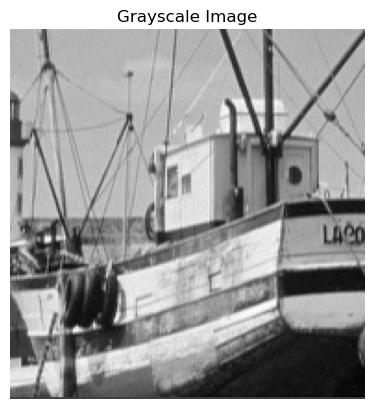

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


image = Image.open("fishing_boat.bmp").convert("L")  # "L" = Grayscale
image_array = np.array(image)  # 转换为 NumPy 数组


plt.imshow(image_array, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.show()


5(b)

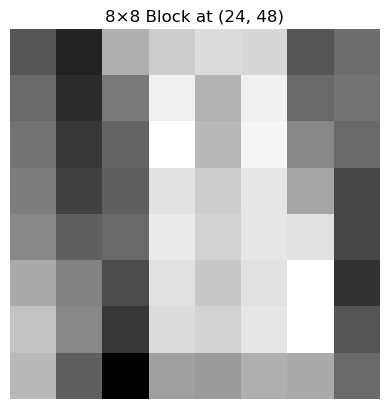

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image and convert it to grayscale
image = Image.open("fishing_boat.bmp").convert("L")  # Convert to grayscale ('L' mode)
image_array = np.array(image)  # Convert the image to a NumPy array

# Compute the starting indices of the 8×8 block (Python uses 0-based indexing)
x_start, y_start = 8 * 3 - 1, 8 * 6 - 1  # Adjusting for 0-based index

# Extract the 8×8 block from the image
block = image_array[y_start:y_start+8, x_start:x_start+8]

# Display the extracted 8×8 block
plt.imshow(block, cmap='gray')  # Show in grayscale
plt.title(f"8×8 Block at ({x_start+1}, {y_start+1})")  # Title with 1-based index for clarity
plt.axis("off")  # Hide axis labels
plt.show()


5(c)

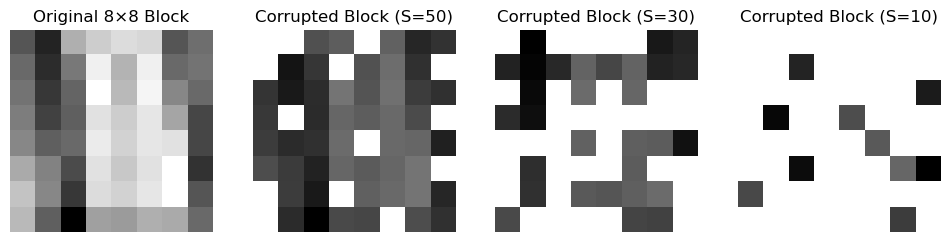

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the grayscale image
image = Image.open("fishing_boat.bmp").convert("L")  # Convert to grayscale
image_array = np.array(image)  # Convert to NumPy array

# Define 8×8 block starting position (Python uses 0-based indexing)
x_start, y_start = 8 * 3 - 1, 8 * 6 - 1  # Adjust for 0-based index

# Extract the 8×8 block
block = image_array[y_start:y_start+8, x_start:x_start+8]

# Function to corrupt an 8×8 block with S sensed pixels
def corrupt_block(block, S):
    corrupted = np.full_like(block, fill_value=255)  # Set all to white (255)
    pixel_indices = np.random.choice(block.size, S, replace=False)  # Randomly select S pixels
    x_coords, y_coords = np.unravel_index(pixel_indices, block.shape)  # Convert to 2D indices
    corrupted[x_coords, y_coords] = block[x_coords, y_coords]  # Keep selected pixels
    return corrupted

# Define different S values
S_values = [50, 30, 10]

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Original 8×8 block
axes[0].imshow(block, cmap='gray')
axes[0].set_title("Original 8×8 Block")
axes[0].axis("off")

# Corrupted blocks with different S values
for i, S in enumerate(S_values):
    corrupted_block = corrupt_block(block, S)
    axes[i+1].imshow(corrupted_block, cmap='gray')
    axes[i+1].set_title(f"Corrupted Block (S={S})")
    axes[i+1].axis("off")

plt.show()


6(a)

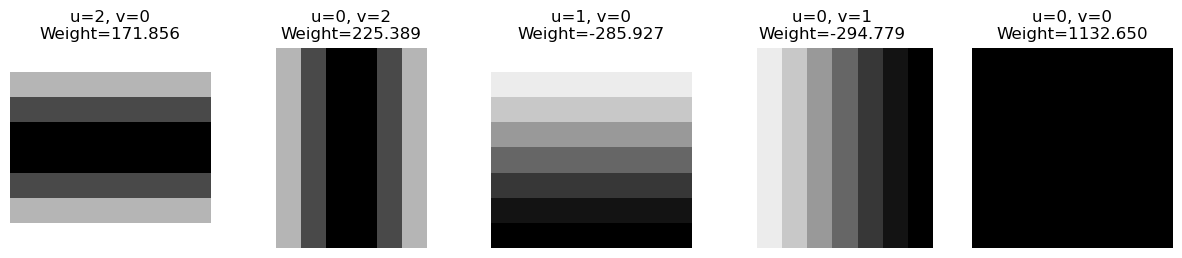

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import Lasso
from scipy.fftpack import dct, idct

# ---------------------------
# Step 1: Load Grayscale Image
# ---------------------------
image_path = "fishing_boat.bmp"  # Make sure this file exists
original_image = Image.open(image_path).convert("L")  # Convert to grayscale
image_array = np.array(original_image)  # Convert to NumPy array

# ---------------------------
# Step 2: Extract 8×8 Block
# ---------------------------
x_start, y_start = 8 * 3 - 1, 8 * 6 - 1  # Convert to 0-based indexing
block = image_array[y_start:y_start+8, x_start:x_start+8]  # Extract 8×8 block

# ---------------------------
# Step 3: Simulate Corruption (S = 30)
# ---------------------------
S = 30  # Number of sensed pixels
mask = np.zeros_like(block, dtype=bool)
indices = np.random.choice(block.size, S, replace=False)  # Random selection of S pixels
x_coords, y_coords = np.unravel_index(indices, block.shape)
mask[x_coords, y_coords] = True  # Mark selected pixels as "sensed"

corrupted_block = np.full_like(block, fill_value=255)  # White background
corrupted_block[mask] = block[mask]  # Keep only S pixels

# ---------------------------
# Step 4: Apply LASSO for DCT Coefficients Estimation
# ---------------------------
# Compute DCT basis matrix
def dct_2d_basis(N):
    basis = np.zeros((N, N, N, N))
    for u in range(N):
        for v in range(N):
            for x in range(N):
                for y in range(N):
                    alpha_u = np.sqrt(1/N) if u == 0 else np.sqrt(2/N)
                    alpha_v = np.sqrt(1/N) if v == 0 else np.sqrt(2/N)
                    basis[u, v, x, y] = (
                        alpha_u * alpha_v *
                        np.cos(np.pi * (2*x+1) * u / (2*N)) *
                        np.cos(np.pi * (2*y+1) * v / (2*N))
                    )
    return basis.reshape(N*N, N*N)  # Reshape for LASSO

N = 8
A = dct_2d_basis(N)
C_prime = block.flatten()[mask.flatten()]  # Observed pixel values
A_sub = A[mask.flatten()]  # Remove rows corresponding to missing pixels

# Solve using LASSO
lasso = Lasso(alpha=0.01, fit_intercept=False, max_iter=10000)
lasso.fit(A_sub, C_prime)
alpha_estimated = lasso.coef_.reshape(N, N)  # Reshape back to 8×8

# ---------------------------
# Step 5: Extract Top 5 Largest Weights
# ---------------------------
top_5_indices = np.argsort(np.abs(alpha_estimated.flatten()))[-5:]  # Get top 5 indices
top_5_u_v = np.array(np.unravel_index(top_5_indices, (N, N))).T  # Convert to (u, v)

# ---------------------------
# Step 6: Display Top 5 Basis Functions
# ---------------------------
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (u, v) in enumerate(top_5_u_v):
    basis_function = np.cos(np.pi * (2*np.arange(N) + 1) * u / (2*N))[:, None] * \
                     np.cos(np.pi * (2*np.arange(N) + 1) * v / (2*N))
    
    axes[i].imshow(basis_function, cmap='gray')
    axes[i].set_title(f"u={u}, v={v}\nWeight={alpha_estimated[u,v]:.3f}")
    axes[i].axis("off")

plt.show()


6(b)

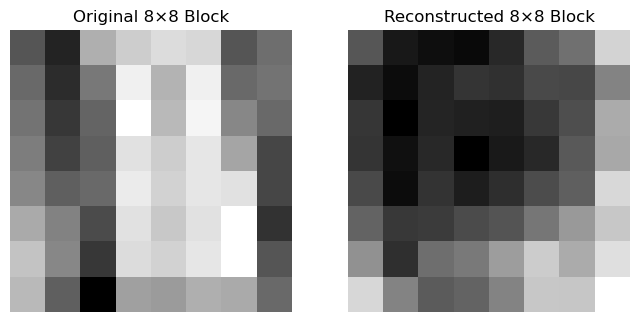

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idct

# ---------------------------
# Step 1: Perform Inverse DCT to Reconstruct the Image Block
# ---------------------------
def idct_2d(coeffs):
    """ Compute the 2D inverse DCT (IDCT) of the coefficient matrix """
    return idct(idct(coeffs.T, norm='ortho').T, norm='ortho')

# Compute reconstructed block from LASSO-estimated DCT coefficients
reconstructed_block = idct_2d(alpha_estimated)

# ---------------------------
# Step 2: Display Original vs. Reconstructed Block
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Original Block
axes[0].imshow(block, cmap='gray')
axes[0].set_title("Original 8×8 Block")
axes[0].axis("off")

# Reconstructed Block
axes[1].imshow(reconstructed_block, cmap='gray')
axes[1].set_title("Reconstructed 8×8 Block")
axes[1].axis("off")

plt.show()


6(c)

In [23]:
from sklearn.metrics import mean_squared_error

# Compute the Mean Squared Error (MSE)
mse_value = mean_squared_error(block.flatten(), reconstructed_block.flatten())

# Print the MSE result
print(f"Mean Squared Error (MSE) between original and reconstructed block: {mse_value:.4f}")

Mean Squared Error (MSE) between original and reconstructed block: 5855.0601
